### Deriving pulsar properties from PWNe - testing
* Pair-production multiplicity via de Jager 2007 $<k> = \frac{N_e({\rm obs})}{2N_{GJ}}$
* Initial spin-down period $P_0$ via van de Swaluw 2001 & the ratio $R_{pwn}/R_{snr}$
* Relate $k$ to the fraction of hadronic particles present in the PWN (and hence hadronic emission component) 

In [1]:
import numpy as np
import astropy.units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from psrqpy import QueryATNF


%matplotlib inline

In [3]:
# Choose parameters from ATNF (or query the whole database)
query = QueryATNF() #params=['Edot','age',"dist","P0","P1","BINARY"])

In [4]:
# Convert them to PANDAS
table = query.table
table = table.to_pandas()

age_all = table["AGE"]
edot_all = table["EDOT"]
dist = table["DIST"]
period = table["P0"]
pdot = table["P1"]

# Compute beam fraction correction
beam_fraction = 9 * np.power(np.log10((period)/10), 2) + 3
beam_fraction /= 100

# Selection to remove milli-second pulsars
sel = np.logical_and(np.invert(np.isnan(age_all)), np.invert(np.isnan(edot_all)))
sel = np.logical_and(sel, dist < 25) #within the Milky Way
sel = np.logical_and(sel, period > 0.01)
sel = np.logical_and(sel, pdot > 1e-18)
sel = np.logical_and(sel, age_all < 1e7)

#print(max(age))
#Now apply selection mask 
age = age_all[sel]

edot = edot_all[sel]
beam_fraction = beam_fraction[sel]

### Pair-production mutiplicity
1) Use Halo paper results for known HESS PWNe to obtain $N_e$ via observations 
* i.e. use energy densities provided and properties of the assumed electron spectrum 
* Note: $E_{\rm min} = 100$GeV, $E_{\rm max}=1,3,10$TeV and $\Gamma = 2.2$

2) Use ATNF catalogue to obtain $N_{GJ}$ for the same pulsars via known properties
* see also eqn(2) of de Jager for the simplified version of $\dot{E}$


In [5]:
import pandas as pd

df = pd.read_csv("Halos/table_pulsars.txt",sep="\t")

In [6]:
df.columns

Index(['Name', 'Edot [erg/s]', 'Size [pc]', 'Distance [kpc]', 'Age [kyr]',
       'Total_E [erg]', 'Volume [cm^3]', 'Edens [eV/cm^]',
       'mean_edens [eV/cm^]', 'min_edens [eV/cm^]', 'max_edens [eV/cm^]'],
      dtype='object')

In [8]:
#These are the ATNF names in order corresponding to the order of pulsars in the table from the halos paper
atnf_names = np.array(["J0659+1414","J0633+1746","J1813-1749","J1833-1034","J1513-5908","J1930+1852","J1420-6048",
                       "J1849-0001","J1846-0258","J0835-4510","J1838-0655","J1418-6058","J1357-6429","J1826-1334",
                       "J1119-6127","J1301-6305","J0534+2200","J1747-2809","J0205+6449","J0007+7303","J1617-5055",
                       "J1023-5746","J1811-1925","J1856+0245","J1640-4631","J1640-4631","J1709-4429","J1907+0602",
                       "J1016-5857","J1016-5857","J1803-2137","J1809-1917","J1617-5055","J1718-3825","J1028-5819",
                       "J1833-0827","J1833-0827","J1857+0143"])

In [10]:
# print(df['Name'])
#Test: where is Geminga in the ATNF? 
print(np.where(query["NAME"]=="J0633+1746"))

(array([268]),)


In [11]:
#Obtain period and pdot from ATNF

period_atnf = np.zeros(len(df))
pdot_atnf = np.zeros(len(df))

for i in range(len(df)):
    psr_idx = np.where(query["NAME"]==atnf_names[i])[0][0]
    
    period_atnf[i] = period[psr_idx]
    pdot_atnf[i] = pdot[psr_idx]
    
print(period_atnf)

[0.38492862 0.23709944 0.04469931 0.06188365 0.15158194 0.13685505
 0.06817988 0.03852259 0.32657129 0.08932839 0.07049824 0.11057301
 0.16610833 0.10148679 0.40796298 0.1845281  0.03339241 0.05215285
 0.06571593 0.31587319 0.06935685 0.11147243 0.064667   0.08090669
 0.20644305 0.20644305 0.10245925 0.10663275 0.10738646 0.10738646
 0.13366692 0.08275527 0.06935685 0.07466992 0.09140323 0.08528815
 0.08528815 0.13976006]


In [15]:
#Define properties of electron spectrum as per the halos paper
E0 = 1. *u.TeV
E2 = 10. *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gam = 2.2

pow2 = 2-Gam
integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))

#Integration constant is total energy (from halos paper) divided by electron spectrum integral
k_intconst = df["Total_E [erg]"]*u.erg / integral2

In [16]:
integral2

<Quantity 4.76967924 TeV1>

In [19]:
pow1 = 1-Gam
integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1

Nel = k_intconst*integral
#Number of electrons derived from observations
# print(Nel)

In [20]:
#for convenience
yr_to_s = (1. * u.yr).to(u.s)

In [22]:
#Edot and age as used in halos paper: 
edot = np.zeros(len(df))
age_halo = np.zeros(len(df))

for i in range(len(df)):
#     print(i)
    edot[i] = df["Edot [erg/s]"][i] 
    age_halo[i] = df["Age [kyr]"][i]
    

edot *= u.erg / u.s
age_halo *= u.kyr
# print(age_halo)

In [24]:
#Just checking:
c.e.gauss

<<class 'astropy.constants.codata2018.EMCODATA2018'> name='Electron charge' value=4.803204712570263e-10 uncertainty=0.0 unit='Fr' reference='CODATA 2018'>

In [25]:
#Calculate age as a function of P0

def age_p0(psr_period,psr_pdot,p0=0.01*u.s,n=3):
    
    brk = n-1
    argp = p0/(psr_period*u.s)
    tau_age = 1. - argp**brk
    tau_age *= (psr_period*u.s)/(brk*psr_pdot)
    
    return tau_age.to(u.yr)

In [26]:
#Range of initial spin periods 
test_p0 = np.linspace(0.01,0.15,15)*u.s
print(test_p0)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15] s


In [27]:
#Calculate N_GJ integral

def calc_ngj(edot_pwn,age_pwn):
    
    ngj_integrand = (6. * c.c * edot_pwn)**0.5 
    ngj_integrand /= c.e.gauss
    ngj_out = ngj_integrand.to(1./u.s)*age_pwn.to(u.s)
        
    return ngj_out#.to(1.)

In [28]:
tau_test = age_p0(period_atnf,pdot_atnf,test_p0[0])

In [29]:
ngj = calc_ngj(edot_pwn=edot,age_pwn=tau_test)

In [30]:
print(ngj[0].to(1.),Nel[0])


6.027170882822084e+44 3.67051292499364e+47


In [31]:
# Pair-production multiplicity factor:
k_multi = Nel / (2.*ngj) 

In [33]:
i=0
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
# print(tau_p0)

In [35]:
ngj_p0 = calc_ngj(edot_pwn=edot[i],age_pwn=tau_p0)
# print(ngj_p0)

J0659+1414 p= 0.3849286233650379 15
J0633+1746 p= 0.2370994416922568 15
J1813-1749 p= 0.044699305261405566 4
J1833-1034 p= 0.06188365001063282 6
J1513-5908 p= 0.15158194339345915 15
J1930+1852 p= 0.136855046957 13
J1420-6048 p= 0.06817987659 6
J1849-0001 p= 0.038522586319205 3
J1846-0258 p= 0.3265712883437141 15
J0835-4510 p= 0.08932838502359318 8


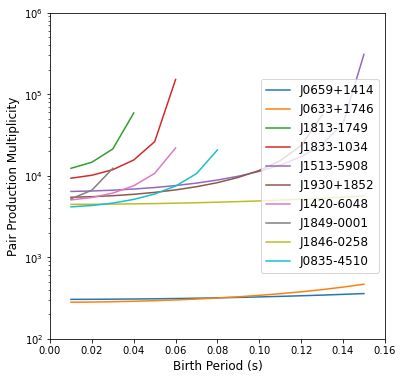

In [37]:
plt.figure(figsize=(6,6))

#Now plot how the pair-production multiplicity varies with P0. 

#Only first 10 in df, as len(df) is a crowded plot
for i in range(10):#len(df)):
    
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(edot[i],tau_p0)

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    print(atnf_names[i],"p=",period_atnf[i],sum(mask))
    plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
    
plt.semilogy()
plt.ylim(100.,1e6)
plt.xlim(0.0,0.16)
plt.ylabel("Pair Production Multiplicity",fontsize=12)
plt.xlabel("Birth Period (s)",fontsize=12)
plt.legend(fontsize=12)

None

[]

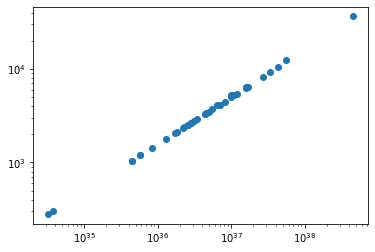

In [38]:
plt.plot(edot,k_multi,"o")
plt.semilogx()
plt.semilogy()

In [39]:
# query.ppdot(showSNRs=True, showtypes='all')

### Maximum particle energy
From Emma et al. 2022 eqn (3):
Maximum energy as a function of spin-down power only
and eqn (4) - maximum gamma-ray energy based on electrons

In [40]:
#Equation 3
def Emax(Edot_psr,eta_e=1.,eta_b=1.):
    Edot_ref = 1e36*u.erg/u.s
    
    E_max = 2.*u.PeV * eta_e * eta_b**0.5 * (Edot_psr/Edot_ref)**0.5
    
    return E_max

#Equation 4
def Emax_gammae(Edot_psr,eta_e=1.,eta_b=1.):
    Edot_ref = 1e36*u.erg/u.s
    
    E_max = 0.9*u.PeV * eta_e**1.3 * eta_b**0.65 * (Edot_psr/Edot_ref)**0.65
    
    return E_max

In [41]:
Emax_psr = Emax(edot)
Emax_psrGamE = Emax_gammae(edot)

Emax_Echeck = 2.15*Emax_psrGamE**0.77 

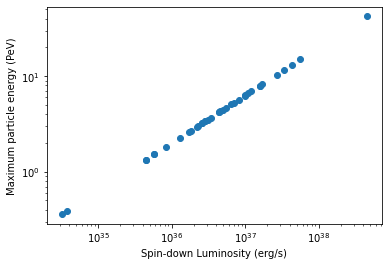

In [42]:
plt.scatter(edot,Emax_psr)
plt.semilogx()
plt.semilogy()
plt.xlabel("Spin-down Luminosity (erg/s)")
plt.ylabel("Maximum particle energy (PeV)")

None

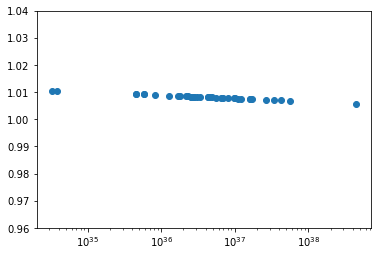

In [43]:
#Check consistency of Emax expressions via ratio
plt.scatter(edot,Emax_psr/Emax_Echeck)
plt.semilogx()
plt.ylim(0.96,1.04)

None

### Initial spin period
* Use eqn(6) of van der Swaluw - ratio of $R_{pwn}/R_{snr}$ can be obtained for e.g. table 1 of halo paper
 - doing this for the full table 2 will need a literature search
* Current spin period via ATNF catalogue
* Moment of inertia $I$ can be calculated, but $\eta_1$ and $\eta_3$ need to be assumed. 


Problem: $E_0$ - feels dangerous to assume this. 

Determine dependency of $P_0$ on assumed $E_0$? Or could assume a standard evolution of $\dot{E}$ towards present day values. 

In [44]:
#Expression for P0 from ratio based on van de Swaluw et al. 

def P0(R_pwn,R_snr,P_t,E0=1e51*u.erg,I=1.4e45*u.g*u.cm**2):
    eta_1 = 1.0
    eta_3 = 1.02
    R_ratio = R_pwn/(eta_3*R_snr)
    P_ratio = 2.*np.pi/P_t
    
    EI_term = 2.*E0 / (eta_1*I)
#     print(EI_term.to(1./u.s**2))
    
    P0 = (EI_term*R_ratio**3. + P_ratio**2)**-0.5
    P0 *= 2*np.pi
    
    return P0.to(u.s)

In [45]:
# atnf_names

In [46]:
#Reduced selection of PWNe (table 1 of halo paper)
Ratnf = ['J0534+2200','J1513-5908','J1833-1034','J1747-2809','J0835-4510','J1826-1334']#add J1825, Geminga
Rsnr = [2.8,38.4,2.98,19.8,19.5,120.]*u.pc #Assume Crab SNR size = PWN size
Rpwn = [2.8,19.2,0.8,2.5,12.2,20.]*u.pc #making a guess for J1825

In [47]:
Patnf = np.zeros(len(Ratnf))

for i in range(len(Ratnf)):
    index = np.where(atnf_names==Ratnf[i])[0][0]
    Patnf[i] = period_atnf[index]

print(Patnf)

[0.03339241 0.15158194 0.06188365 0.05215285 0.08932839 0.10148679]


In [48]:
P_0 = P0(Rpwn,Rsnr,Patnf*u.s)

In [49]:
# print(P_0,Patnf)
#Ratio of P0 derived to current period in ATNF:
print(P_0 / (Patnf*u.s))

[0.16008259 0.10053579 0.53251237 0.91797585 0.12159543 0.61710181]


Now we have both $k$ as a function of $P_0$, for all pulsars/pwne considered in the halos paper, and constraints on $P_0$ for a subset of pwne for which we have more information (e.g. table 1 of the halos paper). 

Dashed lines below indicate the evaluated $P_0$ from the radius ratio. 
Where the lines of the same colour intersect, this gives the pair-production multiplicity for that PWN. 


J0534+2200 p= 0.033392412302258895 P0= 0.00534554380051773 s 3
J1513-5908 p= 0.15158194339345915 P0= 0.015239410525787624 s 15
J1833-1034 p= 0.06188365001063282 P0= 0.032953808907644225 s 6
J1747-2809 p= 0.052152855 P0= 0.04787506158892769 s 5
J0835-4510 p= 0.08932838502359318 P0= 0.010861923156129938 s 8
J1826-1334 p= 0.10148679420759428 P0= 0.06262768489185835 s 10


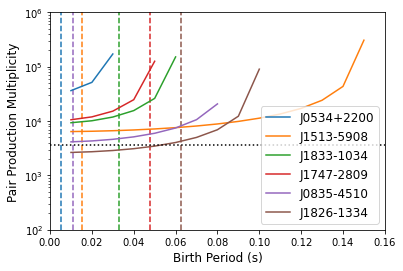

In [50]:
#Add these derived P0s to the plot above of k vs P0. 

for index in range(len(Ratnf)):#len(df)):

    i = np.where(atnf_names==Ratnf[index])[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(edot[i],tau_p0)

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    print(Ratnf[index],"p=",period_atnf[i],"P0=",P_0[index],sum(mask))
    p = plt.plot(test_p0[mask],k_p0[mask],label=Ratnf[index])
    plt.vlines(P_0[index].value,ymin=100.,ymax=1e6,linestyle='--',color=p[0].get_color())
    
plt.semilogy()
plt.ylim(100.,1e6)
plt.xlim(0.0,0.16)
plt.ylabel("Pair Production Multiplicity",fontsize=12)
plt.xlabel("Birth Period (s)",fontsize=12)
plt.legend(fontsize=12,loc=4)
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')

None

In [51]:
2*c.m_p/c.m_e

<Quantity 3672.30534688>

The desired pair-production multiplicity for hadrons from the pulsar surface to reach the PWN is that 
$k \lesssim 2m_p/m_e = 3672 $ which is given by the horizontal dotted line. 

We can therefore exclude the PWNe studied here as being systems in which that could have happened, with the possible exception of Vela and J1825-137. 